In [1]:
from pyvispoly import Point, PolygonWithHoles, VisibilityPolygonCalculator, plot_polygon
import solver
from CAGPSolverMIP import CAGPSolverMIP
from GreedyCAGP import get_greedy_solution
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import distinctipy as distcolors
import lzma

In [2]:
def convert_to_LinearRing(edges: list, pos: dict) -> list[Point]:
    ring = []
    cur_point = next(iter(pos))
    while len(pos):
        x, y = pos.pop(cur_point)
        ring.append(Point(x, y))
        cur_edge = [edge for edge in edges if edge[0] == cur_point or edge[1] == cur_point][0]
        cur_point = cur_edge[0] if cur_edge[1] == cur_point else cur_edge[1]
        edges.remove(cur_edge)
    return ring

In [3]:
G = nx.parse_graphml(lzma.open('/home/yanyan/PythonProjects/CAGP-Solver/db/sbgdb-20200507/polygons/random/fpg/fpg-poly_0000000100.graphml.xz').read())
pos = {}
for node in G.nodes(data=True):
    node_location = tuple(node[1].values())
    node_location = (float(node_location[0]), float(node_location[1]))
    pos[node[0]] = node_location

ring = convert_to_LinearRing(list(G.edges()), pos)
poly = PolygonWithHoles(ring)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-14
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1579 rows, 100 columns and 3158 nonzeros
Model fingerprint: 0x2b298b92
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 71.0000000
Presolve removed 1579 rows and 100 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 82 71 

Optimal solution found (tolerance 1.00e-04)
Best ob

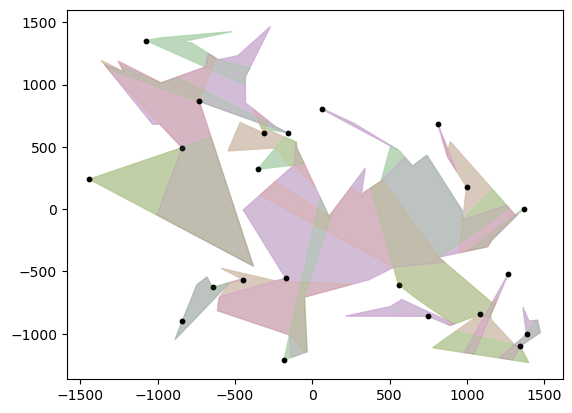

In [4]:
guards = solver.generate_guard_set(poly)
witnesses = solver.generate_witness_set(poly)
G = solver.generate_visibility_graph(guards, witnesses)
greedySolution = get_greedy_solution(guards, witnesses, G)
print("size of greedy solution: ", len(greedySolution))
solverMIP = CAGPSolverMIP(len(greedySolution), poly, guards, witnesses)
solution = solverMIP.solve()

colors = distcolors.get_colors(len(guards))

fig, ax = plt.subplots()
plot_polygon(poly, ax=ax, color="lightgrey")
for s in solution:
    for guard in guards:
        if s.split('k')[0] == guard.id:
            plot_polygon(guard.visibility, ax=ax, color=colors[int(s.split('k')[1])], alpha=0.1)
            plt.scatter(guard.position.x(), guard.position.y(), color='black', s=10)
            

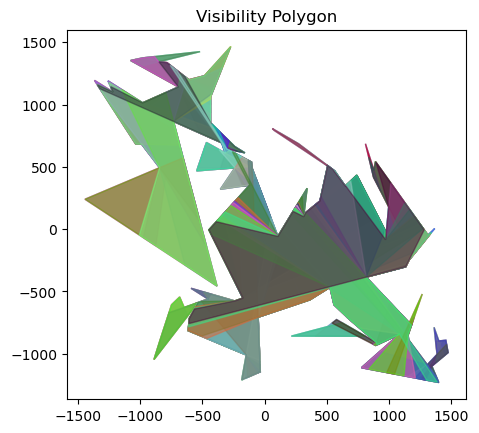

In [5]:
fig, ax = plt.subplots()
# plot_polygon(poly, ax=ax, color="lightgrey")

vis_poly_calc = VisibilityPolygonCalculator(poly)

colors = distcolors.get_colors(len(ring))
vis_polygons = {}

color = 0
for point in ring:
    vis_poly = vis_poly_calc.compute_visibility_polygon(point)
    plot_polygon(vis_poly, ax=ax, color=colors[color], alpha=0.5)
    vis_polygons[(float(point.x()), float(point.y()))] = PolygonWithHoles(vis_poly)
    color += 1

# keys = list(vis_polygons)
# for point1 in keys:
#     color = np.random.rand(3,)
#     for point2 in keys:
#         if point1 == point2:
#             continue
#         if not vis_polygons.get(point1).difference(vis_polygons.get(point2)):
#             x, y = [point1[0], point2[0]], [point1[1], point2[1]]
#             plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)
#             continue
#         if vis_polygons.get(point1).difference(vis_polygons.get(point2))[0].outer_boundary().area() < vis_polygons.get(point1).outer_boundary().area():
#             x, y = [point1[0], point2[0]], [point1[1], point2[1]]
#             plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)

plt.rcParams['figure.dpi']=10000
ax.set_aspect('equal')
plt.title("Visibility Polygon")
plt.show()
